# Introduction
This tutorial will walk you through how to create your own basic AFL model, using publicly available data. The output will be the odds for each team to win. The aim of this tutorial is not to teach you how to code; but rather for someone with very little programming experience to understand exactly what is being done.

For tutorials on Python, and data science, I highly recommend checking out [Datacamp](https://www.datacamp.com/) or [Dataquest](https://www.dataquest.io/). These are free resources that will provide you with the basics of Python and data science fundamentals.

The tutorial will be relatively short. For the full process of a typical data science project, feel free to read any of the predictive model walkthroughs on [Betfair's Github](https://github.com/betfair-datascientists/predictive-models).

## Read in The Data
First, we will read in the data and explore the columns within the dataset. I have condensed the columns down to some key statistics for simplicity, but full AFL datasets are available using the [fitzRoy](https://github.com/jimmyday12/fitzRoy) R package or elsewhere online.

I have collated the data and we will only use a subset of that data for this presentation. Specifically, we'll use the median supercoach score and the elos of each team as features in the model.

In [16]:
# Import libraries
import pandas as pd
import h2o
from h2o.automl import H2OAutoML

In [2]:
# Read in the data
afl = pd.read_csv('afl_modelling.csv')

In [3]:
# Look at the last 9 rows
afl.tail(9)

,date,game_id,season,round,venue,team_1,team_2,home_team_1,margin,winner,supercoach_1,supercoach_2,elo_1,elo_2
1363,2019-03-21,1364,2019,1,M.C.G.,Carlton,Richmond,1,-33,0,76.0,74.5,1192.232026,1661.503449
1364,2019-03-22,1365,2019,1,M.C.G.,Collingwood,Geelong,1,-7,0,78.0,87.0,1527.182906,1544.244870
1365,2019-03-23,1366,2019,1,Adelaide Oval,Adelaide,Hawthorn,1,-32,0,72.0,72.0,1583.123031,1594.130262
1366,2019-03-23,1367,2019,1,Gabba,Brisbane,West Coast,1,44,1,85.0,64.5,1272.898111,1550.133198
1367,2019-03-23,1368,2019,1,Docklands,Sydney,Western Bulldogs,0,-17,0,84.0,68.5,1635.928361,1467.294962
1368,2019-03-23,1369,2019,1,M.C.G.,Port Adelaide Power,Melbourne,0,26,1,74.5,64.5,1504.777529,1566.884537
1369,2019-03-24,1370,2019,1,Sydney Showground,Essendon,GWS,0,-72,0,55.5,84.0,1485.319903,1605.717735
1370,2019-03-24,1371,2019,1,Docklands,St Kilda,Gold Coast,1,1,1,84.5,79.5,1378.118006,1202.430331
1371,2019-03-24,1372,2019,1,Perth Stadium,North Melbourne,Fremantle,0,-82,0,72.0,74.5,1425.514864,1457.565917


As we can see, we have the median supercoach scores for each team, as well as the margin, result and each team's Elo score before the game. Let's take a quick look at the correlation between median supercoach scores and Elo scores with margin, so we can see if these look like they could be good predictors of margin/winning.

In [4]:
# Check the correlations of our columns to margin
afl.corr().margin

game_id        -0.006955
season         -0.011825
round           0.036840
home_team_1     0.139195
margin          1.000000
winner          0.792105
supercoach_1    0.749591
supercoach_2   -0.743541
elo_1           0.394782
elo_2          -0.384503
Name: margin, dtype: float64

It looks like supercoach and Elo are highly correlated with margin. These could be quality predictors of margin/winning. However, we need to ensure that we only use statistics that we have access to before the game. Currently we're using supercoach scores from after the game. This leaks the result. Instead we need to use average supercoach scores from <i>previous games</i> to predict the <i>current game</i>.

## Feature Creation
A "feature" is the stat in the data which we believe will allow our model to predict the outcome better. For example, we can use Elo as a feature because it will obviously allow the model to learn that higher Elos are more likely to beat low Elos.

We're only going to use two features in this model: Elo for each team, and average supercoach scores over the past 10 games.

Let's calculate the average supercoach score for each team for their past 10 matches. To do this, we need to reshape the data from having two teams on each row to only one team on each row (similar to going from a wide dataframe to a long dataframe). We can then find each team's average supercoach scores for the past 10 matches, and then join these stats back to our original dataframe.

### Convert DataFrame from Wide to Long
We need to reshape the dataframe by appending the team 2's data to team 1's data. This is because if use the current shape to calculate moving averages for the home team, we won't include the games where the team plays away. The image below depicts how we will be reshaping the data.

![Wide to Long](wide_to_long.png "Wide to Long")

In [5]:
# Split the dataframe from wide to long

# Get team 1's stats in a dataframe
df1 = (afl[['date', 'game_id', 'season', 'round', 'venue', 'team_1', 'home_team_1', 'supercoach_1', 'elo_1']]
       .rename(columns={'team_1': 'team',
                       'supercoach_1': 'supercoach',
                       'elo_1': 'elo'}))

# Get team 2's stats in a dataframe
df2 = (afl[['date', 'game_id', 'season', 'round', 'venue', 'team_2', 'home_team_1', 'supercoach_2', 'elo_2']]
       .rename(columns={'team_2': 'team',
                        'supercoach_2': 'supercoach',
                        'elo_2': 'elo'}))

# Append these dataframes together to get a long dataframe
long_df = pd.concat([df1, df2], sort=True).sort_values(by='game_id')

In [6]:
# View the last 5 rows of the long df
long_df.tail()

,date,elo,game_id,home_team_1,round,season,supercoach,team,venue
1369,2019-03-24,1485.319903,1370,0,1,2019,55.5,Essendon,Sydney Showground
1370,2019-03-24,1202.430331,1371,1,1,2019,79.5,Gold Coast,Docklands
1370,2019-03-24,1378.118006,1371,1,1,2019,84.5,St Kilda,Docklands
1371,2019-03-24,1425.514864,1372,0,1,2019,72.0,North Melbourne,Perth Stadium
1371,2019-03-24,1457.565917,1372,0,1,2019,74.5,Fremantle,Perth Stadium


## Calculating Moving Averages for Supercoach Scores
As you can see, we now have a dataframe with one team on each row. Let's calculate the average supercoach score for each team over the past 10 games. This piece of code groups the data by the team and then calculates a "rolling" average (an average over a certain amount of games) for the last 10 games. It then shifts the data up so as to not include the current game in the calculations.

In [7]:
# Create supercoach average for the last 10 games played. Call it supercoach_average_last_10
long_df['supercoach_average_last_10'] = long_df.groupby('team').supercoach.transform(lambda x: x.rolling(10).mean().shift())

Now let's look at each team's average last 10 supercoach.

In [8]:
# Look at each team's last average 10 supercoach scores and order it from highest to lowest
(long_df.groupby('team')
 .last()
 .sort_values(by='supercoach_average_last_10', ascending=False)
 [['elo', 'supercoach_average_last_10']]
)

,elo,supercoach_average_last_10
team,,
Essendon,1485.319903,80.05
Richmond,1661.503449,77.40
Geelong,1544.244870,77.20
Adelaide,1583.123031,76.80
Brisbane,1272.898111,76.30
GWS,1605.717735,75.30
Collingwood,1527.182906,75.05
Hawthorn,1594.130262,75.00
Port Adelaide Power,1504.777529,74.60


As we can see, the top sides generally have a higher supercoach average, whereas the bottom sides like Gold Coast, have a lower average supercoach score. Essendon are at the top as they are natually a high scoring supercoach team and also had a strong last 10 games of the 2018 season. Richmond are next, which is expected as they were favourites going into the finals. Our data doesn't include 2018 finals. If it did, we could expect Collingwood and West Coast to be higher up the ladder supercoach average ladder.

## Join Features To Original DataFrame
Let's now merge these average stats back to our original dataframe and use them to create a simple machine learning model. We will then predict the first round of 2019, to see what our model would've given us.

In [9]:
# Put dataframe back into individual rows
afl_with_features = (afl.pipe(pd.merge, long_df[['team', 'game_id', 'supercoach_average_last_10']].rename(columns={'team': 'team_1'}), 
                   on=['team_1', 'game_id'])
 .pipe(pd.merge, long_df[['team', 'game_id', 'supercoach_average_last_10']].rename(columns={'team': 'team_2'}),
       on=['team_2', 'game_id'],
       suffixes=('_1', '_2'))
)

In [10]:
# View last 5 rows
afl_with_features.tail()

,date,game_id,season,round,venue,team_1,team_2,home_team_1,margin,winner,supercoach_1,supercoach_2,elo_1,elo_2,supercoach_average_last_10_1,supercoach_average_last_10_2
1367,2019-03-23,1368,2019,1,Docklands,Sydney,Western Bulldogs,0,-17,0,84.0,68.5,1635.928361,1467.294962,74.25,70.30
1368,2019-03-23,1369,2019,1,M.C.G.,Port Adelaide Power,Melbourne,0,26,1,74.5,64.5,1504.777529,1566.884537,74.60,74.15
1369,2019-03-24,1370,2019,1,Sydney Showground,Essendon,GWS,0,-72,0,55.5,84.0,1485.319903,1605.717735,80.05,75.30
1370,2019-03-24,1371,2019,1,Docklands,St Kilda,Gold Coast,1,1,1,84.5,79.5,1378.118006,1202.430331,72.80,64.35
1371,2019-03-24,1372,2019,1,Perth Stadium,North Melbourne,Fremantle,0,-82,0,72.0,74.5,1425.514864,1457.565917,71.45,69.40


## Modelling With H2O
Now that we have our features (elo for each team and average supercoach score), let's create a model. To simplify things, we're going to use H2O's AutoML function, which automatically creates many models, tunes each model and returns the best model with the highest/lowest metric. For example, if you want a model to be created based on the highest accuracy of choosing the winner, you could use accuracy as your metric. First, let's create a training set, which is the data which the model will be "trained" on. We will then use the model to predict the first round of 2019. 

In [13]:
# Initialise h2o session
h2o.init()

# Create a training set - all the data up to 2018
train = afl_with_features[afl_with_features.season != 2019].copy().reset_index(drop=True)
test = afl_with_features[afl_with_features.season == 2019].copy().reset_index(drop=True)

train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

train_h2o['winner'] = train_h2o['winner'].asfactor()
test_h2o['winner'] = test_h2o['winner'].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.202-b08, mixed mode)
  Starting server from C:\Users\wardj\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\wardj\AppData\Local\Temp\tmp7kkprtmi
  JVM stdout: C:\Users\wardj\AppData\Local\Temp\tmp7kkprtmi\h2o_WardJ_started_from_python.out
  JVM stderr: C:\Users\wardj\AppData\Local\Temp\tmp7kkprtmi\h2o_WardJ_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Australia/Hobart
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,2 months and 14 days
H2O cluster name:,H2O_from_python_WardJ_epexid
H2O cluster total nodes:,1
H2O cluster free memory:,7.089 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [17]:
# Create an AutoML object
aml = H2OAutoML(max_runtime_secs=60, seed=42)

# Train the model
aml.train(y='winner', 
          x=['elo_1', 'elo_2', 'supercoach_average_last_10_1', 'supercoach_average_last_10_2'], 
          training_frame=train_h2o)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [18]:
# Predict the first round
rd_1_predictions = aml.predict(test_h2o).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


In [19]:
# View the round 1 predictions
rd_1_predictions

,predict,p0,p1
0,0,0.915076,0.084924
1,1,0.524170,0.475830
2,1,0.470654,0.529346
3,0,0.718843,0.281157
4,1,0.280624,0.719376
5,1,0.538684,0.461316
6,1,0.547686,0.452314
7,1,0.239074,0.760926
8,1,0.491176,0.508824


In [20]:
# Add the round 1 predictions to the test dataframe
test['model_prob_1'] = rd_1_predictions.p1
test['model_prob_2'] = rd_1_predictions.p0
test['model_odds_1'] = 1 / test['model_prob_1']
test['model_odds_2'] = 1 / test['model_prob_2']

In [22]:
# View the predictions
test[['team_1', 'team_2', 'model_odds_1', 'model_odds_2', 'home_team_1']]

,team_1,team_2,model_odds_1,model_odds_2,home_team_1
0,Carlton,Richmond,11.775242,1.092805,1
1,Collingwood,Geelong,2.101590,1.907779,1
2,Adelaide,Hawthorn,1.889124,2.124702,1
3,Brisbane,West Coast,3.556735,1.391124,1
4,Sydney,Western Bulldogs,1.390093,3.563489,0
5,Port Adelaide Power,Melbourne,2.167713,1.856375,0
6,Essendon,GWS,2.210853,1.825864,0
7,St Kilda,Gold Coast,1.314188,4.182804,1
8,North Melbourne,Fremantle,1.965315,2.035931,0


In [24]:
match_results = pd.read_csv(r'C:\Users\wardj\Documents\Betfair Github\Users\jamesward\afl\afl-model-2019\data\match_results.csv')

In [25]:
match_results.head()

,key,season,round,date,local_start_time,venue,attendance,home_team,home_score,away_team,...,home_q4_goals,home_q4_behinds,away_q1_goals,away_q1_behinds,away_q2_goals,away_q2_behinds,away_q3_goals,away_q3_behinds,away_q4_goals,away_q4_behinds
0,Melbourne_St Kilda_2007_1,2007,1,2007-03-30,1940,M.C.G.,49490,Melbourne,62,St Kilda,...,9,8,2,7,7,7,11,12,13,15
1,Brisbane_Hawthorn_2007_1,2007,1,2007-03-31,1915,Gabba,27104,Brisbane,69,Hawthorn,...,9,15,1,0,2,3,2,6,6,8
2,North Melbourne_Collingwood_2007_1,2007,1,2007-03-31,1410,M.C.G.,42402,North Melbourne,79,Collingwood,...,10,19,2,1,5,5,5,8,12,10
3,Sydney_West Coast_2007_1,2007,1,2007-03-31,1915,Stadium Australia,62586,Sydney,73,West Coast,...,10,13,6,0,10,2,10,6,11,8
4,Fremantle_Port Adelaide Power_2007_1,2007,1,2007-03-31,1410,Subiaco,37425,Fremantle,105,Port Adelaide Power,...,16,9,3,4,6,6,16,7,19,7


In [40]:
afl_with_features['elo_diff'] = afl_with_features['elo_1'] - afl_with_features['elo_2']

Text(0.5,1,'Elo vs Margin')

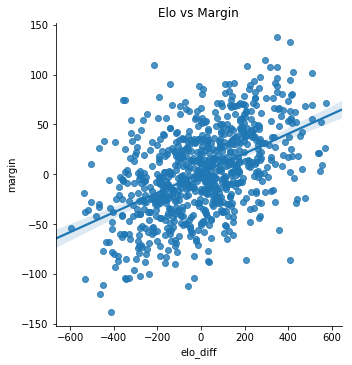

In [41]:
sns.lmplot(x='elo_diff', y='margin', data=afl_with_features.query('season > 2014'))
plt.title("Elo vs Margin")

In [27]:
import seaborn as sns

In [36]:
import matplotlib.pyplot as plt